# Predicting the number from looking at the handwritten image 




## 1. Problem Definition 

 
> The aim is to predict the number from looking at the handwritten image. 

## 2. Data 

There is available on Kaggle https://www.kaggle.com/code/ngbolin/mnist-dataset-digit-recognizer



In [15]:
import itertools 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [5]:
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

## Load Data 

In [6]:
df = pd.read_csv('mnist.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Explolatory Data Analysis 

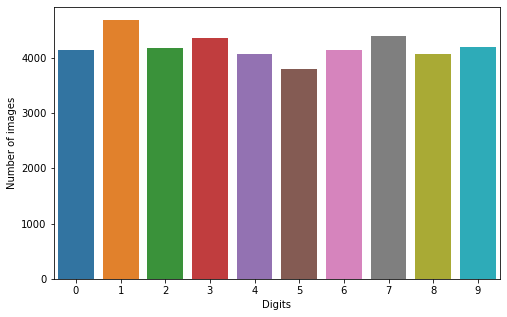

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(x='label',data=df)
plt.xlabel('Digits')
plt.ylabel('Number of images');

## Data Preprocessing 

In [17]:
# split data into train and test 
np.random.seed(42) # for reproducibilty 
X = df.drop('label',axis=1) # images 
y = df['label'] # target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [18]:
X_train.shape,X_test.shape

((37800, 784), (4200, 784))

#### Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [19]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

#### Reshape

In [20]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

#### Target encoding

In [21]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([8, 5, 6, 2, 7, 1, 4, 0, 3, 9], dtype=int64)

In [22]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

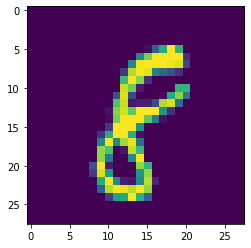

In [23]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

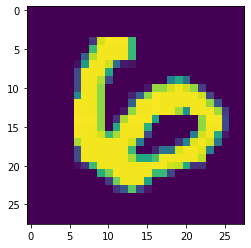

In [24]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

## Modeling 

In [25]:
# function to create the CNN

def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # First convolutional layer.
    model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                     activation=activation, name='layer_conv1'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Again, we will only optimize the activation function.
    model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:
    
    for i in range(num_dense_layers):
        
        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### Hyperparameter Space Tuning 

In [26]:
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')


dim_activation = Categorical(
    categories=['relu', 'sigmoid'], name='activation',
)

In [27]:
# the hyperparameter space grid

param_grid = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

### Define the Objective Function

In [28]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [29]:
@use_named_args(param_grid)
def objective(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with the hyper-parameters.
    # We call the function we created previously.
    model = create_cnn(learning_rate=learning_rate,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       activation=activation)

   
    # Set a learning rate annealer
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    
    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return -accuracy

### Test run

In [30]:
# Before we run the hyper-parameter optimization, 
# let's first check that the everything is working
# by passing some default hyper-parameters.

default_parameters = [1e-5, 1, 16, 'relu']

objective(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 118s 308ms/step - loss: 2.2806 - accuracy: 0.1846 - val_loss: 2.2345 - val_accuracy: 0.3251 - lr: 1.0000e-05
Epoch 2/3
266/266 [==============================] - 74s 279ms/step - loss: 2.1634 - accuracy: 0.4047 - val_loss: 2.0765 - val_accuracy: 0.4561 - lr: 1.0000e-05
Epoch 3/3
266/266 [==============================] - 86s 325ms/step - loss: 1.9698 - accuracy: 0.4741 - val_loss: 1.8476 - val_accuracy: 0.4931 - lr: 1.0000e-05

Accuracy: 49.31%



-0.4931216835975647

### Bayesian Optimization

In [31]:
# gp_minimize performs by default GP Optimization 
# using a Marten Kernel

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    x0=default_parameters, # the initial parameters to test
    acq_func='EI', # the acquisition function
    n_calls=30, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3
266/266 [==============================] - 119s 349ms/step - loss: 2.2670 - accuracy: 0.2061 - val_loss: 2.2129 - val_accuracy: 0.3471 - lr: 1.0000e-05
Epoch 2/3
151/266 [================>.............] - ETA: 28s - loss: 2.1598 - accuracy: 0.3521learning rate: 1.1e-04
num_dense_layers: 4
num_dense_nodes: 291
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 107s 308ms/step - loss: 0.7350 - accuracy: 0.7961 - val_loss: 0.2649 - val_accuracy: 0.9220 - lr: 1.0828e-04
Epoch 2/3
266/266 [==============================] - 78s 295ms/step - loss: 0.2069 - accuracy: 0.9363 - val_loss: 0.1540 - val_accuracy: 0.9579 - lr: 1.0828e-04
Epoch 3/3
266/266 [==============================] - 84s 317ms/step - loss: 0.1330 - accuracy: 0.9598 - val_loss: 0.1126 - val_accuracy: 0.9667 - lr: 1.0828e-04

Accuracy: 96.67%

learning rate: 2.2e-04
num_dense_layers: 2
num_dense_nodes: 354
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 4166s 16s/step - loss: 0.5071 - accuracy: 0.8640 - val_loss: 0.1729 - val_accuracy: 0.9500 - lr: 2.2026e-04
Epoch 2/3
266/266 [==============================] - 81s 306ms/step - loss: 0.1290 - accuracy: 0.9601 - val_loss: 0.0944 - val_accuracy: 0.9714 - lr: 2.2026e-04
Epoch 3/3
266/266 [==============================] - 79s 298ms/step - loss: 0.0822 - accuracy: 0.9754 - val_loss: 0.0736 - val_accuracy: 0.9746 - lr: 2.2026e-04

Accuracy: 97.46%

learning rate: 1.4e-03
num_dense_layers: 4
num_dense_nodes: 250
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 78s 195ms/step - loss: 0.2589 - accuracy: 0.9174 - val_loss: 0.0791 - val_accuracy: 0.9770 - lr: 0.0014
Epoch 2/3
266/266 [==============================] - 47s 175ms/step - loss: 0.0672 - accuracy: 0.9786 - val_loss: 0.0529 - val_accuracy: 0.9854 - lr: 0.0014
Epoch 3/3
266/266 [==============================] - 48s 181ms/step - loss: 0.0476 - accuracy: 0.9844 - val_loss: 0.0486 - val_accuracy: 0.9852 - lr: 0.0014

Accuracy: 98.52%

learning rate: 2.0e-03
num_dense_layers: 1
num_dense_nodes: 22
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 129s 149ms/step - loss: 0.3373 - accuracy: 0.8954 - val_loss: 0.0904 - val_accuracy: 0.9741 - lr: 0.0020
Epoch 2/3
266/266 [==============================] - 38s 144ms/step - loss: 0.0776 - accuracy: 0.9763 - val_loss: 0.0704 - val_accuracy: 0.9791 - lr: 0.0020
Epoch 3/3
266/266 [==============================] - 38s 141ms/step - loss: 0.0538 - accuracy: 0.9835 - val_loss: 0.0512 - val_accuracy: 0.9862 - lr: 0.0020

Accuracy: 98.62%

learning rate: 1.0e-02
num_dense_layers: 5
num_dense_nodes: 135
activation: relu

Epoch 1/3


C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 54s 160ms/step - loss: 0.5304 - accuracy: 0.8197 - val_loss: 0.1454 - val_accuracy: 0.9619 - lr: 0.0100
Epoch 2/3
266/266 [==============================] - 39s 147ms/step - loss: 0.1402 - accuracy: 0.9623 - val_loss: 0.1159 - val_accuracy: 0.9714 - lr: 0.0100
Epoch 3/3
266/266 [==============================] - 42s 157ms/step - loss: 0.1100 - accuracy: 0.9705 - val_loss: 0.1083 - val_accuracy: 0.9741 - lr: 0.0100

Accuracy: 97.41%

learning rate: 9.2e-03
num_dense_layers: 2
num_dense_nodes: 405
activation: sigmoid



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 63s 185ms/step - loss: 2.3923 - accuracy: 0.1023 - val_loss: 2.3387 - val_accuracy: 0.1087 - lr: 0.0092
Epoch 2/3
266/266 [==============================] - 49s 185ms/step - loss: 2.3492 - accuracy: 0.0999 - val_loss: 2.3407 - val_accuracy: 0.1087 - lr: 0.0092
Epoch 3/3
266/266 [==============================] - ETA: 0s - loss: 2.3440 - accuracy: 0.1012
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00461316155269742.
266/266 [==============================] - 45s 170ms/step - loss: 2.3440 - accuracy: 0.1012 - val_loss: 2.3369 - val_accuracy: 0.0902 - lr: 0.0092

Accuracy: 9.02%

learning rate: 6.8e-04
num_dense_layers: 4
num_dense_nodes: 383
activation: sigmoid

Epoch 1/3


C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 60s 191ms/step - loss: 2.1355 - accuracy: 0.1836 - val_loss: 1.1238 - val_accuracy: 0.6151 - lr: 6.8388e-04
Epoch 2/3
266/266 [==============================] - 46s 174ms/step - loss: 0.5687 - accuracy: 0.8158 - val_loss: 0.3227 - val_accuracy: 0.9021 - lr: 6.8388e-04
Epoch 3/3
266/266 [==============================] - 50s 189ms/step - loss: 0.2590 - accuracy: 0.9215 - val_loss: 0.1921 - val_accuracy: 0.9402 - lr: 6.8388e-04

Accuracy: 94.02%

learning rate: 1.0e-02
num_dense_layers: 2
num_dense_nodes: 508
activation: relu

Epoch 1/3


C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 58s 177ms/step - loss: 2.3225 - accuracy: 0.1068 - val_loss: 2.3013 - val_accuracy: 0.1130 - lr: 0.0100
Epoch 2/3
266/266 [==============================] - 43s 163ms/step - loss: 2.3020 - accuracy: 0.1095 - val_loss: 2.3019 - val_accuracy: 0.1130 - lr: 0.0100
Epoch 3/3
266/266 [==============================] - ETA: 0s - loss: 2.3021 - accuracy: 0.1098
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
266/266 [==============================] - 44s 167ms/step - loss: 2.3021 - accuracy: 0.1098 - val_loss: 2.3015 - val_accuracy: 0.1130 - lr: 0.0100

Accuracy: 11.30%

learning rate: 2.5e-03
num_dense_layers: 5
num_dense_nodes: 74
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 56s 162ms/step - loss: 0.3130 - accuracy: 0.8979 - val_loss: 0.0817 - val_accuracy: 0.9770 - lr: 0.0025
Epoch 2/3
266/266 [==============================] - 39s 147ms/step - loss: 0.0780 - accuracy: 0.9757 - val_loss: 0.0599 - val_accuracy: 0.9820 - lr: 0.0025
Epoch 3/3
266/266 [==============================] - 40s 150ms/step - loss: 0.0501 - accuracy: 0.9846 - val_loss: 0.0980 - val_accuracy: 0.9693 - lr: 0.0025

Accuracy: 96.93%

learning rate: 1.0e-02
num_dense_layers: 1
num_dense_nodes: 5
activation: relu

Epoch 1/3


C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 55s 165ms/step - loss: 1.7221 - accuracy: 0.2682 - val_loss: 1.5378 - val_accuracy: 0.3437 - lr: 0.0100
Epoch 2/3
266/266 [==============================] - 40s 150ms/step - loss: 1.4593 - accuracy: 0.3843 - val_loss: 1.4058 - val_accuracy: 0.4235 - lr: 0.0100
Epoch 3/3
266/266 [==============================] - 38s 142ms/step - loss: 1.3767 - accuracy: 0.4280 - val_loss: 1.3514 - val_accuracy: 0.4492 - lr: 0.0100

Accuracy: 44.92%

learning rate: 9.1e-04
num_dense_layers: 2
num_dense_nodes: 73
activation: relu

Epoch 1/3


C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 52s 159ms/step - loss: 0.3716 - accuracy: 0.8850 - val_loss: 0.1113 - val_accuracy: 0.9693 - lr: 9.1142e-04
Epoch 2/3
266/266 [==============================] - 41s 154ms/step - loss: 0.0909 - accuracy: 0.9711 - val_loss: 0.0740 - val_accuracy: 0.9794 - lr: 9.1142e-04
Epoch 3/3
266/266 [==============================] - 41s 153ms/step - loss: 0.0653 - accuracy: 0.9795 - val_loss: 0.0641 - val_accuracy: 0.9812 - lr: 9.1142e-04

Accuracy: 98.12%

learning rate: 6.1e-03
num_dense_layers: 1
num_dense_nodes: 199
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 58s 174ms/step - loss: 0.1686 - accuracy: 0.9462 - val_loss: 0.0593 - val_accuracy: 0.9844 - lr: 0.0061
Epoch 2/3
266/266 [==============================] - 40s 149ms/step - loss: 0.0501 - accuracy: 0.9843 - val_loss: 0.0527 - val_accuracy: 0.9820 - lr: 0.0061
Epoch 3/3
266/266 [==============================] - 40s 150ms/step - loss: 0.0370 - accuracy: 0.9879 - val_loss: 0.0512 - val_accuracy: 0.9857 - lr: 0.0061

Accuracy: 98.57%

learning rate: 7.1e-05
num_dense_layers: 5
num_dense_nodes: 512
activation: relu

Epoch 1/3


C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 62s 189ms/step - loss: 0.6890 - accuracy: 0.8084 - val_loss: 0.2269 - val_accuracy: 0.9339 - lr: 7.1449e-05
Epoch 2/3
266/266 [==============================] - 50s 190ms/step - loss: 0.1771 - accuracy: 0.9451 - val_loss: 0.1360 - val_accuracy: 0.9553 - lr: 7.1449e-05
Epoch 3/3
266/266 [==============================] - 50s 188ms/step - loss: 0.1170 - accuracy: 0.9625 - val_loss: 0.1051 - val_accuracy: 0.9672 - lr: 7.1449e-05

Accuracy: 96.72%

learning rate: 5.2e-04
num_dense_layers: 1
num_dense_nodes: 235
activation: relu

Epoch 1/3


C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 55s 162ms/step - loss: 0.3848 - accuracy: 0.8915 - val_loss: 0.1234 - val_accuracy: 0.9656 - lr: 5.1918e-04
Epoch 2/3
266/266 [==============================] - 40s 152ms/step - loss: 0.0997 - accuracy: 0.9701 - val_loss: 0.0836 - val_accuracy: 0.9767 - lr: 5.1918e-04
Epoch 3/3
266/266 [==============================] - 43s 162ms/step - loss: 0.0684 - accuracy: 0.9789 - val_loss: 0.0659 - val_accuracy: 0.9825 - lr: 5.1918e-04

Accuracy: 98.25%

learning rate: 1.0e-06
num_dense_layers: 1
num_dense_nodes: 353
activation: relu

Epoch 1/3


C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


266/266 [==============================] - 68s 214ms/step - loss: 2.3094 - accuracy: 0.1085 - val_loss: 2.2919 - val_accuracy: 0.1262 - lr: 1.0000e-06
Epoch 2/3
266/266 [==============================] - 58s 220ms/step - loss: 2.2765 - accuracy: 0.1602 - val_loss: 2.2595 - val_accuracy: 0.1992 - lr: 1.0000e-06
Epoch 3/3
266/266 [==============================] - 62s 234ms/step - loss: 2.2430 - accuracy: 0.2557 - val_loss: 2.2256 - val_accuracy: 0.3294 - lr: 1.0000e-06

Accuracy: 32.94%

learning rate: 2.0e-03
num_dense_layers: 1
num_dense_nodes: 162
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 71s 267ms/step - loss: 0.0388 - accuracy: 0.9875 - val_loss: 0.0570 - val_accuracy: 0.9833 - lr: 0.0020

Accuracy: 98.33%



### Analyze results

In [32]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % gp_.fun

'Best score=-0.9862'

In [33]:
gp_.x

[0.002032550520012156, 1, 22, 'relu']

In [34]:
gp_.space

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
       Integer(low=1, high=5, prior='uniform', transform='normalize'),
       Integer(low=5, high=512, prior='uniform', transform='normalize'),
       Categorical(categories=('relu', 'sigmoid'), prior=None)])

In [35]:
print("""Best parameters:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- activation = %s""" % (gp_.x[0], 
                gp_.x[1],
                gp_.x[2],
                gp_.x[3]))

Best parameters:
- learning rate=0.002033
- num_dense_layers=1
- num_nodes=22
- activation = relu


### Convergence

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

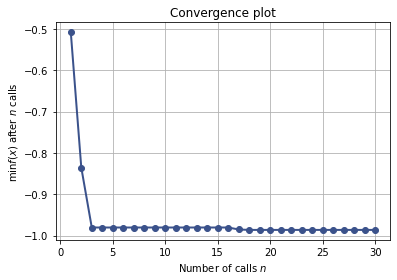

In [36]:
plot_convergence(gp_)

### Partially dependency plots


In [37]:
dim_names = ['learning_rate', 'num_dense_nodes', 'num_dense_layers']

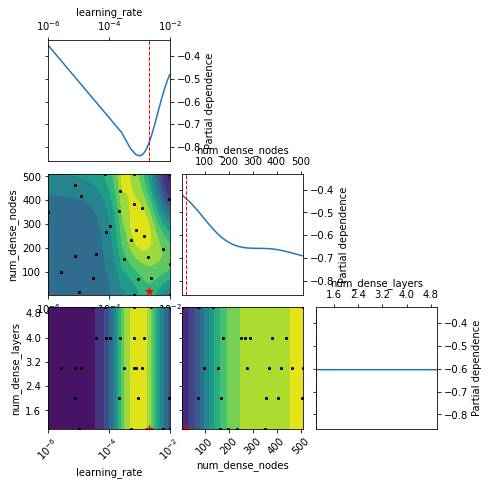

In [38]:
plot_objective(result=gp_, plot_dims=dim_names)
plt.show()

### Evaluation order


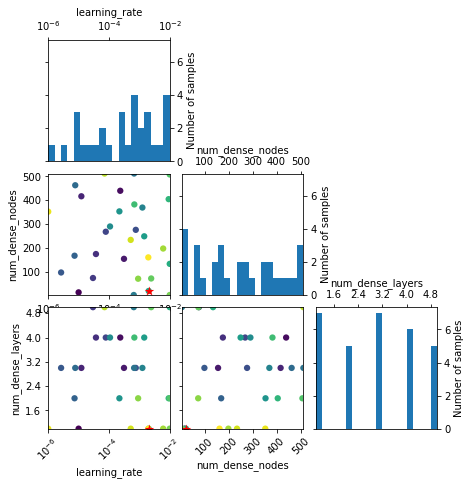

In [39]:
plot_evaluations(result=gp_, plot_dims=dim_names)
plt.show()

### Evaluate the model

In [40]:
# load best model

model = load_model(path_best_model)

In [41]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 23s 16ms/step - loss: 0.0584 - accuracy: 0.9817


In [42]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.05839197337627411
accuracy 0.9816666841506958


#### Confusion matrix

In [43]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

132/132 [==============================] - 28s 15ms/step


array([[403,   0,   0,   0,   1,   0,   2,   0,   2,   0],
       [  0, 469,   1,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0, 407,   1,   5,   0,   0,   1,   5,   1],
       [  0,   0,   2, 492,   0,   3,   0,   2,   5,   2],
       [  0,   0,   0,   0, 392,   0,   3,   0,   0,   2],
       [  0,   0,   0,   1,   0, 334,   2,   0,   2,   0],
       [  0,   0,   0,   0,   0,   0, 398,   0,   4,   0],
       [  0,   1,   4,   0,   1,   0,   0, 425,   4,   3],
       [  0,   0,   1,   0,   1,   1,   0,   1, 399,   0],
       [  0,   0,   0,   1,   5,   0,   0,   1,   5, 404]], dtype=int64)

Text(0.5, 13.421126458070283, 'Predicted label')

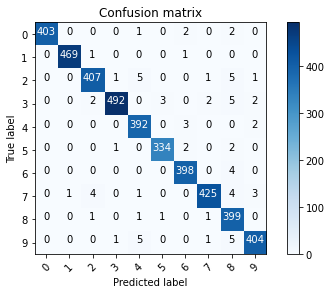

In [44]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')